# Exercise 3.1- Object proposals

## 1. Familiarise yourself with the data and visualize some examples with the ground-truth bounding boxes.

In [1]:
import os
import random
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import glob

def parse_annotations(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(float(bndbox.find('xmin').text))
        ymin = int(float(bndbox.find('ymin').text))
        xmax = int(float(bndbox.find('xmax').text))
        ymax = int(float(bndbox.find('ymax').text))
        boxes.append((xmin, ymin, xmax, ymax))
    return boxes


In [2]:
def visualize_with_matplotlib(image_path, boxes, ax):
    # Read the image and convert it to RGB
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    
    # Add bounding boxes
    for (xmin, ymin, xmax, ymax) in boxes:
        width = xmax - xmin
        height = ymax - ymin
        rect = plt.Rectangle((xmin, ymin), width, height,
                             fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
    ax.axis('off')  # Hide axis ticks
    ax.set_title(os.path.basename(image_path))


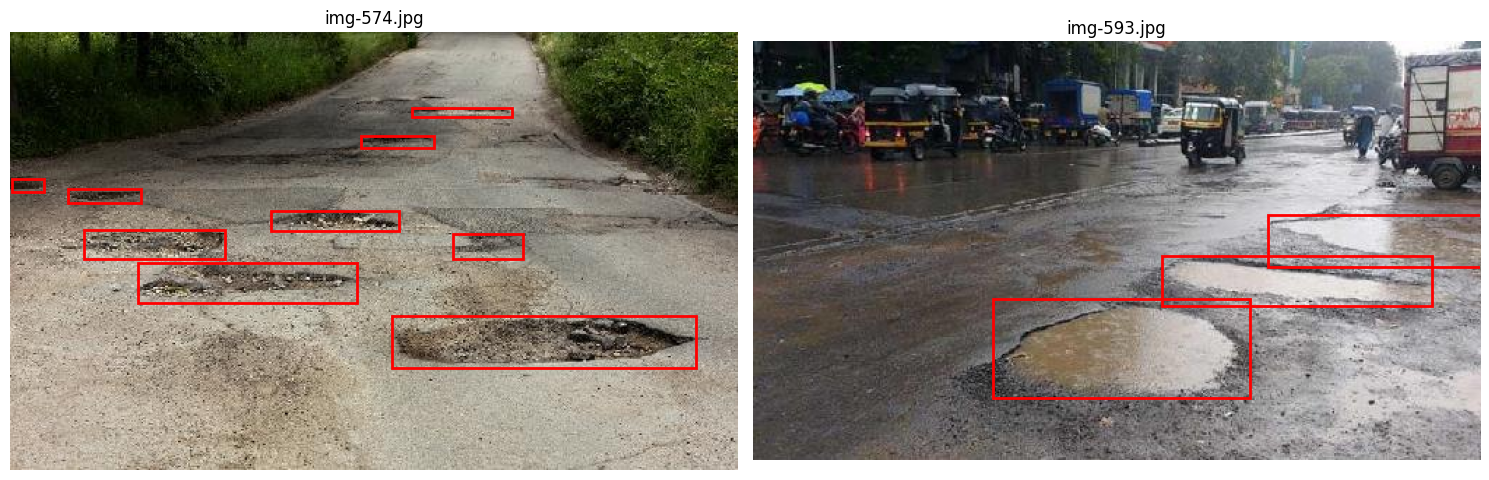

In [4]:
# Path to your data directory (images and annotations in the same folder)
data_dir = f'../Potholes/annotated-images'  # Replace with your data folder path

# Get all XML files in the data directory
annotation_files = [f for f in os.listdir(data_dir) if f.endswith('.xml')]

annotation_files = random.sample(annotation_files, 2)

# Create subplots
fig, axes = plt.subplots(1, len(annotation_files), figsize=(15, 5))

for idx, annotation_file in enumerate(annotation_files):
    # Get the corresponding image file
    image_file = annotation_file.replace('.xml', '.jpg')  # Adjust if your images have a different extension
    
    # Construct full paths
    annotation_path = os.path.join(data_dir, annotation_file)
    image_path = os.path.join(data_dir, image_file)
    
    # Check if image file exists
    if not os.path.exists(image_path):
        print(f"Image file {image_path} not found.")
        continue
    
    # Parse annotations
    boxes = parse_annotations(annotation_path)
    
    # Visualize
    visualize_with_matplotlib(image_path, boxes, axes[idx])

plt.tight_layout()
plt.show()

## 2. Extract object proposals for all the images of the dataset (e.g. Selecting Search, Edge Boxes, etc). Note that you may have to resize the images before you run SS for better efficiency.

In [5]:
def resize_image(image, max_dim=600):
    h, w = image.shape[:2]
    if max(h, w) > max_dim:
        scale = max_dim / max(h, w)
        image = cv2.resize(image, (int(w * scale), int(h * scale)))
    return image

def get_selective_search():
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    return ss

def extract_proposals(image, ss, strategy='fast'):
    ss.setBaseImage(image)
    if strategy == 'fast':
        ss.switchToSelectiveSearchFast()
    elif strategy == 'quality':
        ss.switchToSelectiveSearchQuality()
    else:
        raise ValueError("Strategy not recognized. Use 'fast' or 'quality'.")

    rects = ss.process()
    return rects

def visualize_proposals(image, rects, num_show=100):
    for i, rect in enumerate(rects[:num_show]):
        x, y, w, h = rect
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Top {num_show} Selective Search Proposals')
    plt.show()


In [12]:
def process_dataset(data_dir, output_dir, max_dim=600, strategy='fast'):
    # Initialize Selective Search
    ss = get_selective_search()

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get all image files (adjust the pattern if your images have different extensions)
    image_files = glob.glob(os.path.join(data_dir, '*.jpg'))
    print(f'Found {len(image_files)} images.')

    for image_file in image_files:
        print(f'Processing {image_file}')
        # Read and resize image
        image = cv2.imread(image_file)
        image_resized = resize_image(image, max_dim=max_dim)

        # Extract proposals
        rects = extract_proposals(image_resized, ss, strategy=strategy)

        # Save or process the proposals as needed
        # For example, you can save the proposals to a file
        base_name = os.path.basename(image_file)
        proposal_file = os.path.join(output_dir, base_name.replace('.jpg', '.txt'))

        with open(proposal_file, 'w') as f:
            for rect in rects:
                x, y, w, h = rect
                f.write(f'{x},{y},{w},{h}\n')

        # Optionally visualize proposals
        # visualize_proposals(image_resized.copy(), rects)



In [13]:
output_dir = '../object_proposals'     # Replace with your desired output folder
#process_dataset(data_dir, output_dir, max_dim=600, strategy='quality')


In [14]:
def generate_edge_boxes(image_path, model_path='model.yml.gz', max_proposals=2000, min_score=0.01):
    # Check if the model file exists
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Structured Edge Detection model file '{model_path}' not found.")
    
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image {image_path}")
        return []

    # Convert the image to 32-bit floating point format and normalize
    image = image.astype('float32') / 255.0

    # Initialize Edge Boxes and StructuredEdgeDetection
    edge_boxes = cv2.ximgproc.createEdgeBoxes()
    edge_boxes.setMaxBoxes(max_proposals)
    edge_boxes.setMinScore(min_score)

    # Load the pre-trained edge detection model
    edge_detector = cv2.ximgproc.createStructuredEdgeDetection(model_path)
    edges = edge_detector.detectEdges(image)  # Edge probability map
    orientation_map = edge_detector.computeOrientation(edges)  # Orientation map

    # Generate edge boxes proposals using the edges and orientation map
    boxes, scores = edge_boxes.getBoundingBoxes(edges, orientation_map)
    proposals = [(int(box[0]), int(box[1]), int(box[2]), int(box[3]), float(score)) for box, score in zip(boxes, scores)]
    
    # Sort proposals by score in descending order
    proposals = sorted(proposals, key=lambda x: x[4], reverse=True)
    return proposals


def process_dataset_with_edge_boxes(data_dir, output_dir, max_proposals=2000, min_score=0.01):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get all image files in the data directory
    image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

    for image_file in image_files:
        print(f"Processing {image_file}")
        
        # Full path to image
        image_path = os.path.join(data_dir, image_file)

        # Generate Edge Boxes proposals
        proposals = generate_edge_boxes(image_path, max_proposals=max_proposals, min_score=min_score)

        # Save proposals to a file
        base_name = os.path.splitext(image_file)[0]
        proposal_file = os.path.join(output_dir, base_name + '.txt')
        
        with open(proposal_file, 'w') as f:
            for x, y, w, h, score in proposals:
                f.write(f"{x},{y},{w},{h},{score:.4f}\n")

        print(f"Saved {len(proposals)} proposals for {image_file}")

In [15]:
proposal_dir = '../object_proposals_edge'  # Directory to save proposal files
#process_dataset_with_edge_boxes(data_dir, proposal_dir, max_proposals=2000, min_score=0.01)


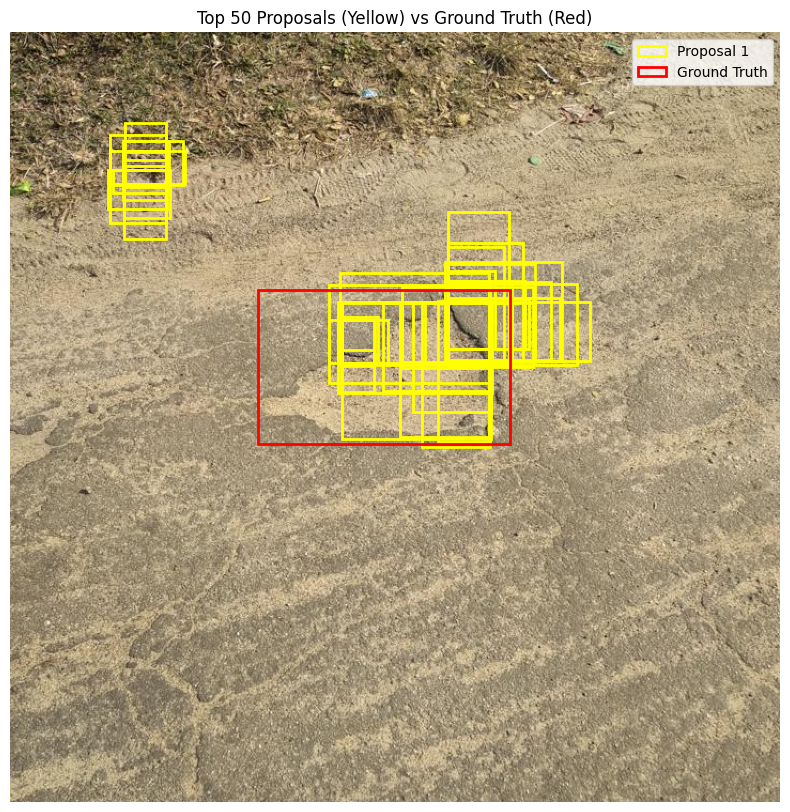

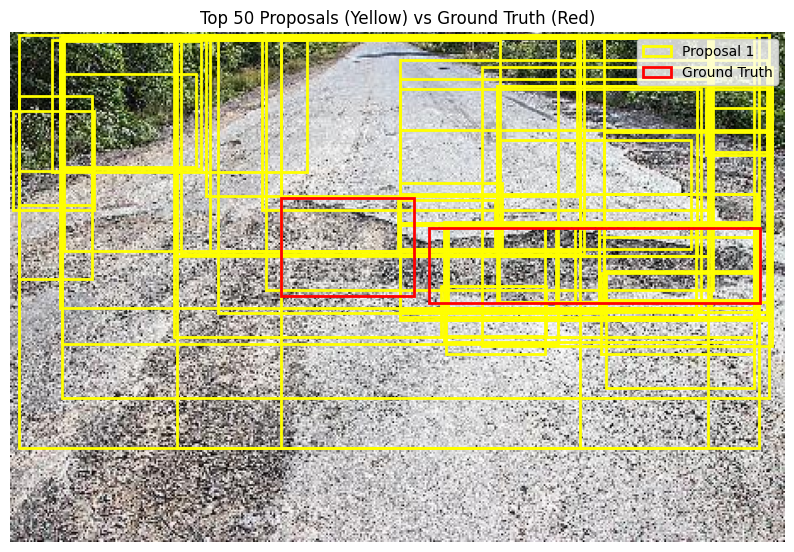

In [18]:
def visualize_top_proposals(image_file, proposals, gt_boxes, top_n=10):
    # Load the image
    image = cv2.imread(image_file)
    if image is None:
        print(f"Failed to load image {image_file}")
        return
    
    # Convert the image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    ax = plt.gca()

    # Draw the top proposals
    for i, proposal in enumerate(proposals[:top_n]):
        x, y, w, h = map(int, proposal[:4])  # Ignore the score by using only the first four elements
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='yellow', facecolor='none', label=f'Proposal {i+1}' if i == 0 else None)
        ax.add_patch(rect)
    
    # Draw ground truth boxes in a different color for comparison
    for gt_box in gt_boxes:
        xmin, ymin, xmax, ymax = gt_box
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none', label='Ground Truth' if gt_box == gt_boxes[0] else None)
        ax.add_patch(rect)

    plt.legend(loc="upper right")
    plt.title(f"Top {top_n} Proposals (Yellow) vs Ground Truth (Red)")
    plt.axis('off')
    plt.show()

# Load training set from JSON file
json_file = '../Potholes/splits.json'  # Path to JSON file with 'train' list
with open(json_file, 'r') as f:
    train_data = json.load(f)
train_image_names = [os.path.splitext(name)[0] for name in train_data['train']]  # Remove .xml suffix if present

# Select two random images from the training set
random_images = random.sample(train_image_names, 2)

# Visualize the top 10 proposals for each random image
for image_name in random_images:
    image_file = os.path.join(data_dir, f"{image_name}.jpg")
    proposal_file = os.path.join(proposal_dir, f"{image_name}.txt")
    
    # Updated proposal parsing to handle the score as a float
    with open(proposal_file, 'r') as f:
        proposals = [(*map(int, line.strip().split(',')[:4]), float(line.strip().split(',')[4])) for line in f.readlines()]


    # Load ground truth boxes for this image
    xml_file = os.path.join(data_dir, f"{image_name}.xml")
    gt_boxes = parse_annotations(xml_file)  # Assumes you have a parse_ground_truth function as defined earlier
    
    # Visualize top 10 proposals
    visualize_top_proposals(image_file, proposals, gt_boxes, top_n=50)

## 3. Evaluate the extracted proposals on the training set of the dataset and determine the number of required proposals.

In [19]:
def compute_iou(boxA, boxB):
    # boxA and boxB are (xmin, ymin, xmax, ymax)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interWidth = max(0, xB - xA + 1)
    interHeight = max(0, yB - yA + 1)
    interArea = interWidth * interHeight

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # Calculate the union area, check for zero to avoid division by zero
    unionArea = boxAArea + boxBArea - interArea
    if unionArea == 0:
        return 0.0

    iou = interArea / float(unionArea)
    return iou


def convert_to_xmin_ymin_xmax_ymax(proposal):
    """Convert (x, y, w, h) format to (xmin, ymin, xmax, ymax) format."""
    x, y, w, h = proposal
    xmin = x
    ymin = y
    xmax = x + w
    ymax = y + h
    return (xmin, ymin, xmax, ymax)

def evaluate_proposals(data_dir, proposal_dir, json_file, iou_threshold=0.5, max_proposals_list=[100, 500, 1000, 2000, 3000, 5000]):
    # Load training set image names from JSON file
    with open(json_file, 'r') as f:
        train_data = json.load(f)
    train_image_names = set([os.path.splitext(name)[0] for name in train_data['train']])  # Remove .xml suffix

    # Initialize recall list
    recall_at_n = {n: [] for n in max_proposals_list}

    for image_name in train_image_names:
        # Load ground truth boxes
        xml_file = os.path.join(data_dir, f"{image_name}.xml")
        gt_boxes = parse_annotations(xml_file)  # Assumes parse_annotations function is available

        # Load proposals
        proposal_file = os.path.join(proposal_dir, f"{image_name}.txt")
        # Adjust this line in the evaluate_proposals_on_training_set function
        with open(proposal_file, 'r') as f:
            proposals = []
            for line in f:
                parts = line.strip().split(',')
                if len(parts) >= 5:
                    # Parse x, y, w, h as integers and score as float
                    proposals.append((*map(int, parts[:4]), float(parts[4])))
                elif len(parts) == 4:
                    # If score is missing, use a default score of 0.0
                    proposals.append((*map(int, parts[:4]), 0.0))
                else:
                    print(f"Skipping invalid line in {proposal_file}: {line.strip()}")
        
        # Evaluate recall at different proposal counts
        for max_proposals in max_proposals_list:
            proposals_subset = proposals[:max_proposals]
            hits = 0
            for gt_box in gt_boxes:
                found = False
                for proposal in proposals_subset:
                    x, y, w, h, _ = proposal
                    proposal_box = (x, y, x + w, y + h)
                    iou = compute_iou(proposal_box, gt_box)
                    if iou >= iou_threshold:
                        found = True
                        break
                if found:
                    hits += 1
            recall = hits / len(gt_boxes) if gt_boxes else 0
            recall_at_n[max_proposals].append(recall)

    # Compute average recall at each proposal count
    avg_recall = {n: np.mean(recall_at_n[n]) for n in max_proposals_list}

    # Plot Recall vs Number of Proposals
    plt.figure(figsize=(8, 6))
    plt.plot(max_proposals_list, [avg_recall[n] for n in max_proposals_list], marker='o')
    plt.xlabel('Number of Proposals')
    plt.ylabel('Average Recall')
    plt.title(f'Average Recall vs Number of Proposals (IoU >= {iou_threshold})')
    plt.grid(True)
    plt.show()

    # Print the average recall values
    for n in max_proposals_list:
        print(f"Average Recall at {n} proposals: {avg_recall[n]:.4f}")

    return avg_recall


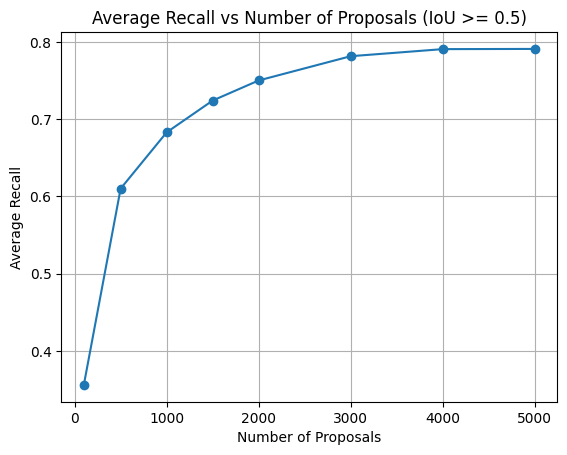

Average Recall at 100 proposals: 0.3562
Average Recall at 500 proposals: 0.6101
Average Recall at 1000 proposals: 0.6829
Average Recall at 1500 proposals: 0.7240
Average Recall at 2000 proposals: 0.7500
Average Recall at 3000 proposals: 0.7814
Average Recall at 4000 proposals: 0.7905
Average Recall at 5000 proposals: 0.7908


In [20]:
json_file = 'Potholes/splits.json' # JSON file containing 'train' list

max_proposals_list = [100, 500, 1000, 1500, 2000, 3000, 4000, 5000]
avg_recall = evaluate_proposals(data_dir, output_dir, json_file, iou_threshold=0.5, max_proposals_list=max_proposals_list)


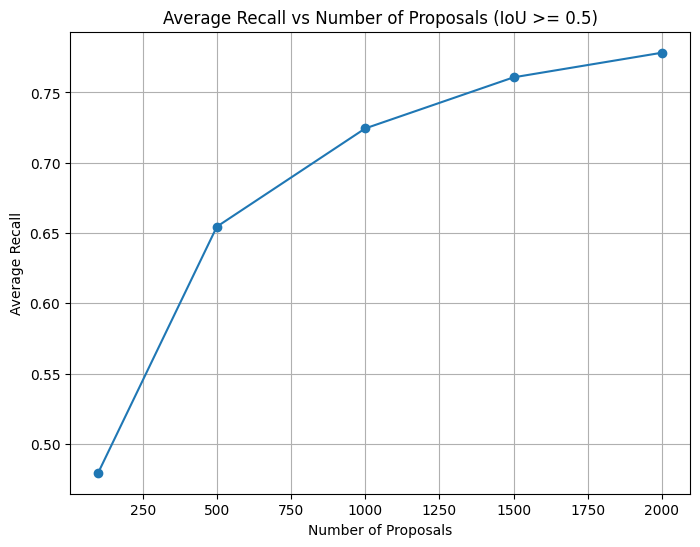

Average Recall at 100 proposals: 0.4794
Average Recall at 500 proposals: 0.6545
Average Recall at 1000 proposals: 0.7244
Average Recall at 1500 proposals: 0.7607
Average Recall at 2000 proposals: 0.7783


{100: 0.4794364293202575,
 500: 0.6545073187989982,
 1000: 0.7243937969892514,
 1500: 0.7607431511708699,
 2000: 0.7782631416231913}

In [ ]:

json_file = 'Potholes/splits.json' # JSON file containing 'train' list

max_proposals_list = [100, 500, 1000, 1500, 2000]

evaluate_proposals(data_dir, proposal_dir, json_file, iou_threshold=0.5, max_proposals_list=max_proposals_list)


## 4. Prepare the proposals for the training of the object detector. This requires assigning a label (i.e., class or background label) to each proposal.

In [22]:
def label_proposals(proposals, gt_boxes, iou_threshold=0.5):
    labeled_proposals = []

    for proposal in proposals:
        x, y, w, h, score = proposal
        proposal_box = (x, y, x + w, y + h)  # Convert to (xmin, ymin, xmax, ymax) format
        
        # Check IoU with each ground truth box
        is_foreground = False
        for gt_box in gt_boxes:
            iou = compute_iou(proposal_box, gt_box)
            if iou >= iou_threshold:
                labeled_proposals.append((x, y, w, h, 'pothole'))  # Label as foreground
                is_foreground = True
                break
        
        # If no sufficient overlap, label as background
        if not is_foreground:
            labeled_proposals.append((x, y, w, h, 'background'))

    return labeled_proposals


In [26]:
def balance_proposals(labeled_proposals, foreground_label='pothole', ratio=2):
    foreground = [p for p in labeled_proposals if p[4] == foreground_label]
    background = [p for p in labeled_proposals if p[4] == 'background']
    
    # Sample background to achieve the desired ratio
    balanced_background = random.sample(background, min(len(background), len(foreground) * ratio))
    
    # Combine and shuffle
    balanced_proposals = foreground + balanced_background
    random.shuffle(balanced_proposals)
    
    return balanced_proposals

def save_labeled_proposals(image_name, labeled_proposals, output_dir):
    output_file = os.path.join(output_dir, f"{image_name}_labeled_proposals.json")
    data = [{'x': x, 'y': y, 'w': w, 'h': h, 'label': label} for x, y, w, h, label in labeled_proposals]
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)


In [34]:
for image_name in train_image_names:
    # Load proposals and ground truth boxes
    proposal_file = os.path.join(proposal_dir, f"{image_name}.txt")
    with open(proposal_file, 'r') as f:
        proposals = []
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 5:
                # Parse x, y, w, h as integers and score as float
                proposals.append((*map(int, parts[:4]), float(parts[4])))
            elif len(parts) == 4:
                # If score is missing, use a default score of 0.0
                proposals.append((*map(int, parts[:4]), 0.0))
            else:
                print(f"Skipping invalid line in {proposal_file}: {line.strip()}")

    xml_file = os.path.join(data_dir, f"{image_name}.xml")
    gt_boxes = parse_annotations(xml_file)  # Load ground truth boxes

    # Label proposals based on IoU with ground truth
    labeled_proposals = label_proposals(proposals, gt_boxes, iou_threshold=0.5)

    # Balance foreground and background proposals
    balanced_proposals = balance_proposals(labeled_proposals)

    # Save labeled proposals
    save_labeled_proposals(image_name, balanced_proposals, output_dir)


In [40]:
def visualize_multiple_pothole_proposals(data_dir, proposal_dir, image_names, num_images=5, top_n=10):
    """
    Visualizes pothole proposals for a batch of images.
    
    Parameters:
        data_dir (str): Directory containing images and XML annotations.
        proposal_dir (str): Directory containing proposal files.
        image_names (list): List of image names (without extension).
        num_images (int): Number of images to visualize.
        top_n (int): Number of top pothole proposals to display.
    """
    # Select a random subset of images to visualize
    selected_images = random.sample(image_names, num_images)

    for image_name in selected_images:
        # Load image and ground truth
        image_file = os.path.join(data_dir, f"{image_name}.jpg")
        xml_file = os.path.join(data_dir, f"{image_name}.xml")
        gt_boxes = parse_annotations(xml_file)  # Load ground truth boxes

        # Load proposals
        proposal_file = os.path.join(proposal_dir, f"{image_name}.txt")
        with open(proposal_file, 'r') as f:
            proposals = [(*map(int, line.strip().split(',')[:4]), float(line.strip().split(',')[4])) for line in f.readlines()]

        # Label proposals based on IoU with ground truth
        labeled_proposals = label_proposals(proposals, gt_boxes, iou_threshold=0.5)

        # Visualize top pothole proposals
        print(f"Visualizing {image_name}")
        visualize_pothole_proposals(image_file, labeled_proposals, gt_boxes, top_n=top_n)


Visualizing img-178


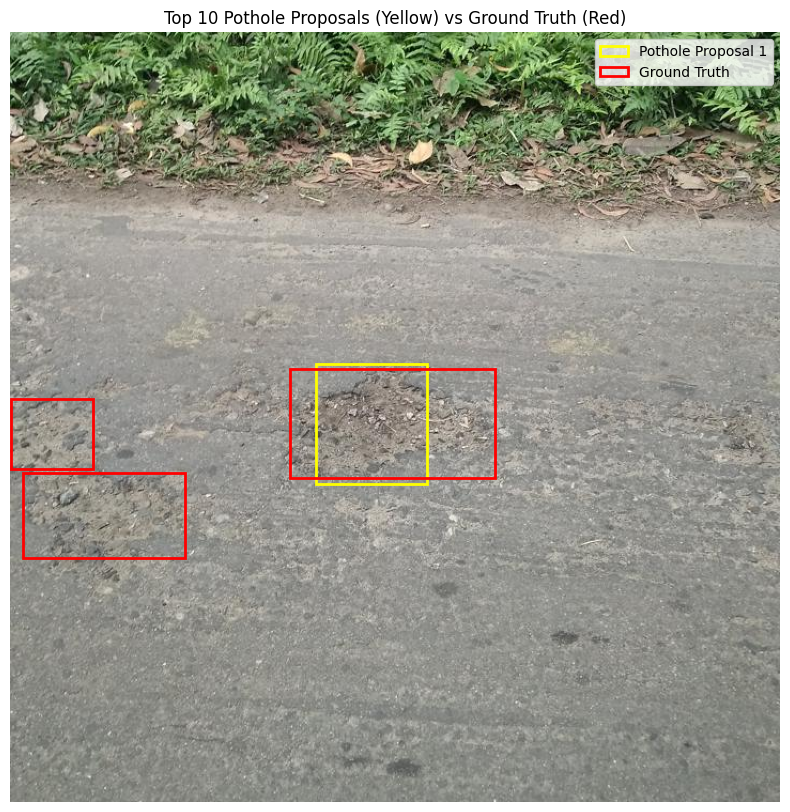

Visualizing img-494


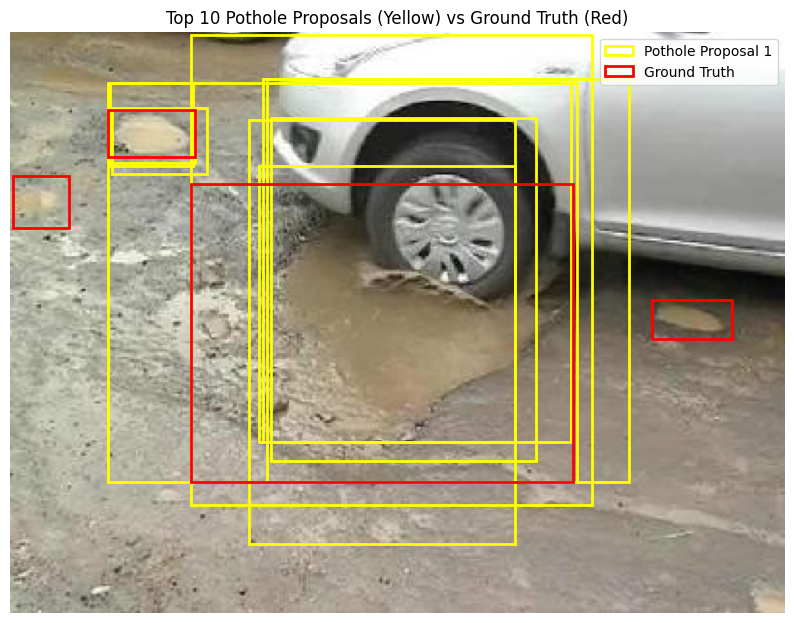

Visualizing img-336


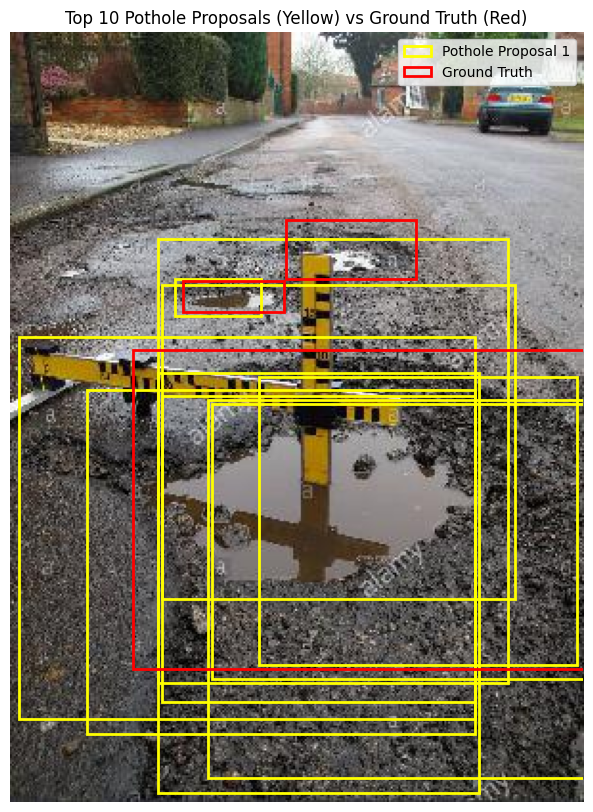

Visualizing img-491


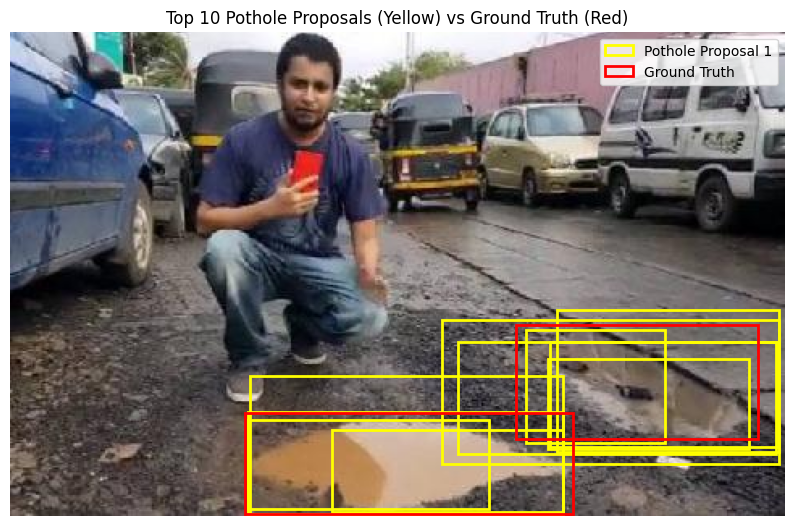

Visualizing img-508


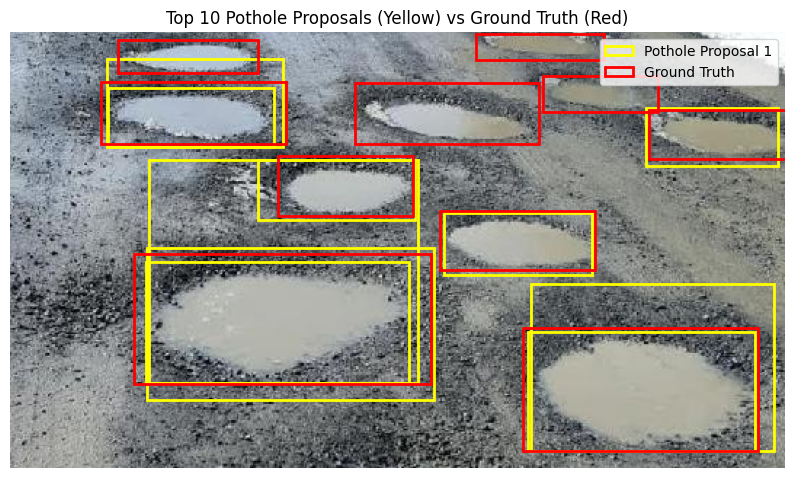

In [41]:
train_image_names = [os.path.splitext(name)[0] for name in os.listdir(data_dir) if name.endswith('.jpg')]

# Visualize 5 images with their pothole proposals
visualize_multiple_pothole_proposals(data_dir, proposal_dir, train_image_names, num_images=5, top_n=10)
